## Compare LightGBM in the case of binary class (Sell, Buy)

In [1]:
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import lightgbm as lgb
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    backtest_strategy,
    display_report,
    plot_feature_imp,
    plot_strategy,
    select_threshold,
    tune_params,
)

warnings.filterwarnings("ignore")

In [2]:
METRIC = "average_precision"
FPR_MAX = 0.01
TEST_SIZE = 500
TIMEOUT = 600

In [3]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [4]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [5]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [6]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [7]:
interest_rate = wk_df["r"].values

## Control LightGBM Classifier without new data

In [8]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

### Split dataset

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [10]:
params = tune_params(
    X_train, y_train, METRIC, TIMEOUT, max_iter=10, max_dep=14, n_splits=10
)

[I 2024-02-19 00:20:16,460] A new study created in memory with name: no-name-031bfe41-7068-4ba2-8186-64447f807eac


[I 2024-02-19 00:20:17,166] Trial 0 finished with value: 0.5281971222365826 and parameters: {'n_estimators': 10, 'lambda_l1': 9.975507409190717e-05, 'lambda_l2': 0.0026568795174116543, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9412660193861806, 'feature_fraction_bynode': 0.700901728913941, 'bagging_fraction': 0.40951542213203884, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 5, 'extra_trees': True}. Best is trial 0 with value: 0.5281971222365826.
[I 2024-02-19 00:20:17,380] Trial 1 finished with value: 0.5364320401104674 and parameters: {'n_estimators': 10, 'lambda_l1': 9.11255522558605e-05, 'lambda_l2': 0.00841186035405606, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9899342275785848, 'feature_fraction_bynode': 0.7250470433988445, 'bagging_fraction': 0.3802247462577368, 'bagging_freq': 3, 'min_child_samples': 79, 'num_grad_quant_bins': 11, 'max_depth'

Number of finished trials: 150
Best trial:
  Number: 133
  Value: 0.6720719047911469
  Params: 
    n_estimators: 10
    lambda_l1: 2.5066281887450154e-07
    lambda_l2: 2.2195704580875195e-08
    num_leaves: 86
    min_sum_hessian_in_leaf: 2.678322479011187e-05
    feature_fraction: 0.6355227592562425
    feature_fraction_bynode: 0.8535854555712786
    bagging_fraction: 0.9773722086085288
    bagging_freq: 5
    min_child_samples: 9
    num_grad_quant_bins: 7
    max_depth: 14
    extra_trees: False


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": METRIC,
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9773722086085288,
                                bagging_freq=5, extra_trees=False,
                                feature_fraction=0.6355227592562425,
                                feature_fraction_bynode=0.8535854555712786,
                                lambda_l1=2.5066281887450154e-07,
                                lambda_l2=2.2195704580875195e-08, max_depth=14,
                                metric='average_precision', min_child_samples=9,
                                min_sum_hessian_in_leaf=2.678322479011187e-05,
                                n_estimators=10, num_grad_quant_bins=7,
                                num_leaves=86, objective='binary',
                                random_state=1968, verbosity=-1))])

In [13]:
# In-sample score
pipe.score(X_train, y_train)

0.9057539682539683

In [14]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       477
           1       0.89      0.93      0.91       531

    accuracy                           0.91      1008
   macro avg       0.91      0.90      0.91      1008
weighted avg       0.91      0.91      0.91      1008



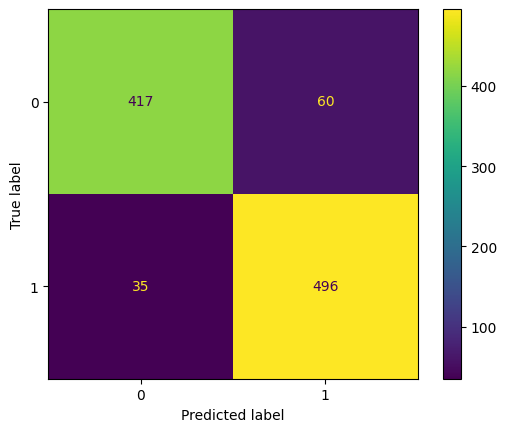

In [15]:
tn, fp, fn, tp = display_report(y_train, in_sample_preds)

In [16]:
fpr_max = fp / (tn + fp)
if fpr_max:
    fpr_max = min(fpr_max, FPR_MAX)
else:
    fpr_max = 1e-4
print(fpr_max)

0.01


In [17]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=fpr_max
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.63


In [18]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [19]:
pipe.score(X_test, y_test)

0.43

              precision    recall  f1-score   support

           0       0.63      0.28      0.39       299
           1       0.41      0.75      0.53       201

    accuracy                           0.47       500
   macro avg       0.52      0.52      0.46       500
weighted avg       0.54      0.47      0.45       500



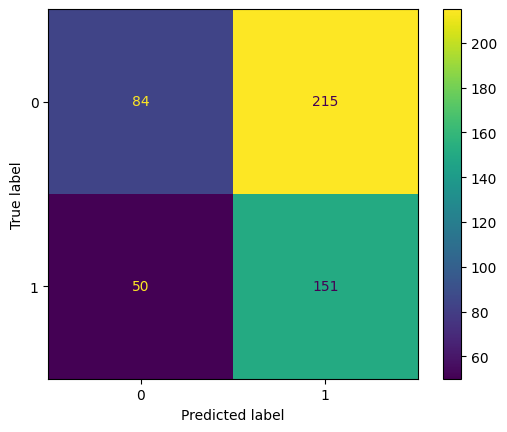

In [20]:
tn, fp, fn, tp = display_report(y_test, predictions)

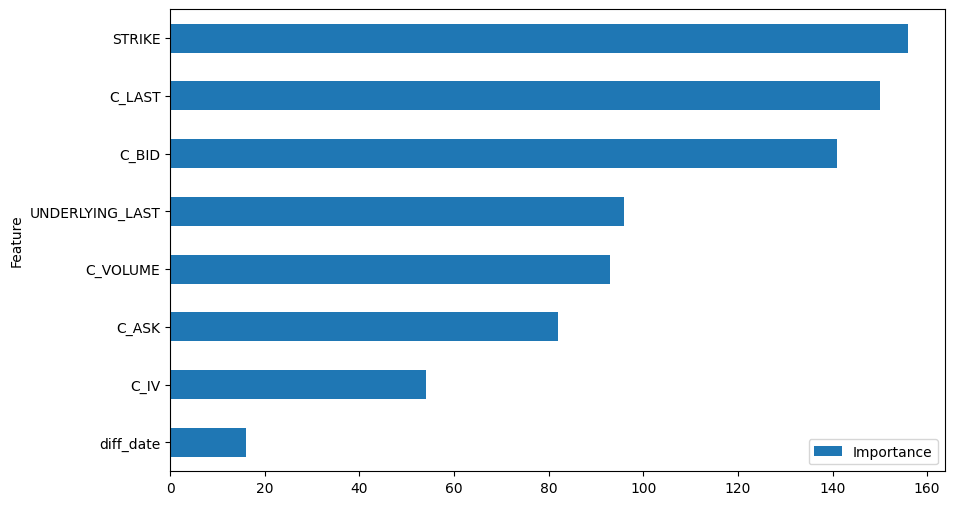

In [21]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [22]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_out"])

### Backtesting

In [23]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [24]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-11,0,470.0,6.01,2022-01-31,449.910004,0.0,-6.010000,0.000000,-6.010000
2022-01-12,0,470.0,6.99,2022-02-02,457.350006,0.0,-6.990000,0.000000,-13.000000
2022-01-13,0,465.0,6.84,2022-02-02,457.350006,0.0,-6.840000,0.000000,-19.840000
2022-01-14,0,465.0,7.14,2022-02-04,448.700012,0.0,-7.140000,0.000000,-26.980000
2022-01-17,0,465.0,7.42,2022-02-07,447.260010,0.0,-7.420000,0.000000,-34.400000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,127.639996,26.509847
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.0,0.309993,127.639996,26.819840
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,127.639996,27.059833


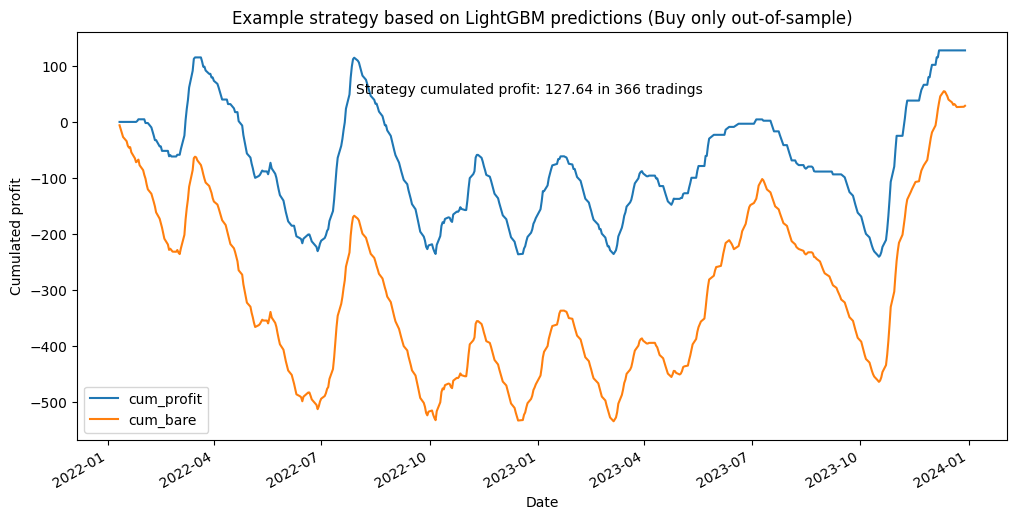

In [25]:
plot_strategy(strategy_df, "LightGBM", "(Buy only out-of-sample)")

In [26]:
compare_df["cum_profit_out"] = strategy_df["cum_profit"].values

## LightGBM with data from MC simulation and additional features

In [27]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike", "r"], axis=1),
    ),
    axis=1,
)

In [28]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### Split dataset

In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=TEST_SIZE,
    random_state=1968,
    shuffle=False,
)

### Hyper-parameters tuning using Optuna

In [30]:
params = tune_params(X_train, y_train, METRIC, TIMEOUT, max_iter=10, max_dep=14)

[I 2024-02-19 00:20:49,721] A new study created in memory with name: no-name-a73c066f-8b85-470b-bcd0-4a2e17ec1bb4
[I 2024-02-19 00:20:50,107] Trial 0 finished with value: 0.5311873546904405 and parameters: {'n_estimators': 10, 'lambda_l1': 9.975507409190717e-05, 'lambda_l2': 0.0026568795174116543, 'num_leaves': 242, 'min_sum_hessian_in_leaf': 2.2408746964386374e-05, 'feature_fraction': 0.9412660193861806, 'feature_fraction_bynode': 0.700901728913941, 'bagging_fraction': 0.40951542213203884, 'bagging_freq': 3, 'min_child_samples': 77, 'num_grad_quant_bins': 11, 'max_depth': 5, 'extra_trees': True}. Best is trial 0 with value: 0.5311873546904405.


[I 2024-02-19 00:20:50,461] Trial 1 finished with value: 0.5223077002391696 and parameters: {'n_estimators': 10, 'lambda_l1': 9.11255522558605e-05, 'lambda_l2': 0.00841186035405606, 'num_leaves': 237, 'min_sum_hessian_in_leaf': 1.2849522382878182e-05, 'feature_fraction': 0.9899342275785848, 'feature_fraction_bynode': 0.7250470433988445, 'bagging_fraction': 0.3802247462577368, 'bagging_freq': 3, 'min_child_samples': 79, 'num_grad_quant_bins': 11, 'max_depth': 4, 'extra_trees': True}. Best is trial 0 with value: 0.5311873546904405.
[I 2024-02-19 00:20:50,638] Trial 2 finished with value: 0.6244340891155403 and parameters: {'n_estimators': 10, 'lambda_l1': 2.3844502274134087, 'lambda_l2': 1.3090391721171108e-07, 'num_leaves': 26, 'min_sum_hessian_in_leaf': 0.027770541137801138, 'feature_fraction': 0.7883897813955555, 'feature_fraction_bynode': 0.35280269519555374, 'bagging_fraction': 0.7812406557661463, 'bagging_freq': 4, 'min_child_samples': 41, 'num_grad_quant_bins': 12, 'max_depth': 11

Number of finished trials: 150
Best trial:
  Number: 74
  Value: 0.7076406474210403
  Params: 
    n_estimators: 10
    lambda_l1: 0.7293742490809668
    lambda_l2: 1.1291385204382097e-08
    num_leaves: 229
    min_sum_hessian_in_leaf: 5.610617115868725e-05
    feature_fraction: 0.4738121973484833
    feature_fraction_bynode: 0.7983734849115856
    bagging_fraction: 0.9095247956601926
    bagging_freq: 6
    min_child_samples: 18
    num_grad_quant_bins: 4
    max_depth: 10
    extra_trees: False


In [31]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "clf",
            lgb.LGBMClassifier(
                **params
                | {
                    "random_state": 1968,
                    "objective": "binary",
                    "metric": METRIC,
                    "verbosity": -1,
                    "boosting_type": "gbdt",
                }
            ),
        ),
    ]
)

In [32]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('clf',
                 LGBMClassifier(bagging_fraction=0.9095247956601926,
                                bagging_freq=6, extra_trees=False,
                                feature_fraction=0.4738121973484833,
                                feature_fraction_bynode=0.7983734849115856,
                                lambda_l1=0.7293742490809668,
                                lambda_l2=1.1291385204382097e-08, max_depth=10,
                                metric='average_precision',
                                min_child_samples=18,
                                min_sum_hessian_in_leaf=5.610617115868725e-05,
                                n_estimators=10, num_grad_quant_bins=4,
                                num_leaves=229, objective='binary',
                                random_state=1968, verbosity=-1))])

In [33]:
# In-sample score
pipe.score(X_train, y_train)

0.8452380952380952

In [34]:
in_sample_preds = pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       477
           1       0.82      0.90      0.86       531

    accuracy                           0.85      1008
   macro avg       0.85      0.84      0.84      1008
weighted avg       0.85      0.85      0.84      1008



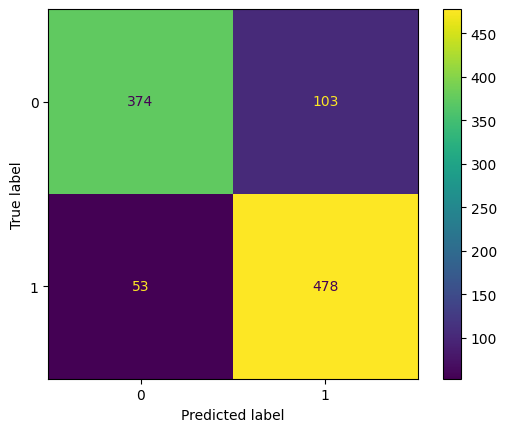

In [35]:
tn, fp, fn, tp = display_report(y_train, in_sample_preds)

In [36]:
fpr_max = fp / (tn + fp)
if fpr_max:
    fpr_max = min(fpr_max, FPR_MAX)
else:
    fpr_max = 1e-4
print(fpr_max)

0.01


In [37]:
# Best threshold given a 5% of maximum false positive rate
threshold = select_threshold(
    pipe.predict_proba(X_train)[:, 1], y_train, fpr_max=fpr_max
)
print(f"Best threshold: {threshold:.2f}")

Best threshold: 0.71


In [38]:
# Use the threshold to make predictions
predictions = np.where(pipe.predict_proba(X_test)[:, 1] >= threshold, 1, 0)

In [39]:
pipe.score(X_test, y_test)

0.432

              precision    recall  f1-score   support

           0       0.61      0.65      0.63       299
           1       0.43      0.39      0.41       201

    accuracy                           0.54       500
   macro avg       0.52      0.52      0.52       500
weighted avg       0.54      0.54      0.54       500



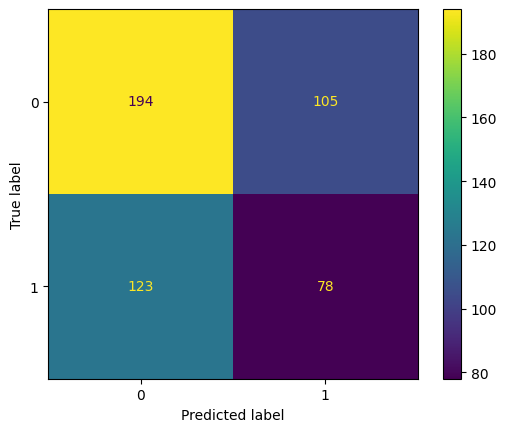

In [40]:
tn, fp, fn, tp = display_report(y_test, predictions)

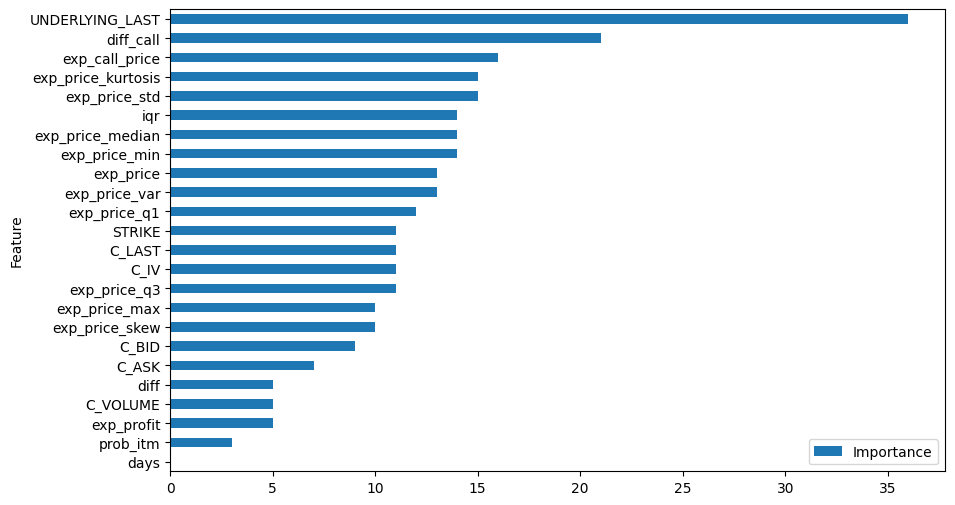

In [41]:
coefficients = pipe.named_steps["clf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [42]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [43]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [44]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2022-01-11,0,470.0,6.01,2022-01-31,449.910004,0.0,-6.010000,0.000000,-6.010000
2022-01-12,0,470.0,6.99,2022-02-02,457.350006,0.0,-6.990000,0.000000,-13.000000
2022-01-13,0,465.0,6.84,2022-02-02,457.350006,0.0,-6.840000,0.000000,-19.840000
2022-01-14,0,465.0,7.14,2022-02-04,448.700012,0.0,-7.140000,0.000000,-26.980000
2022-01-17,0,465.0,7.42,2022-02-07,447.260010,0.0,-7.420000,0.000000,-34.400000
...,...,...,...,...,...,...,...,...,...
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.0,-3.020007,86.819863,26.509847
2023-12-26,0,476.0,6.12,2024-01-19,482.429993,0.0,0.309993,86.819863,26.819840
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.0,0.239993,86.819863,27.059833


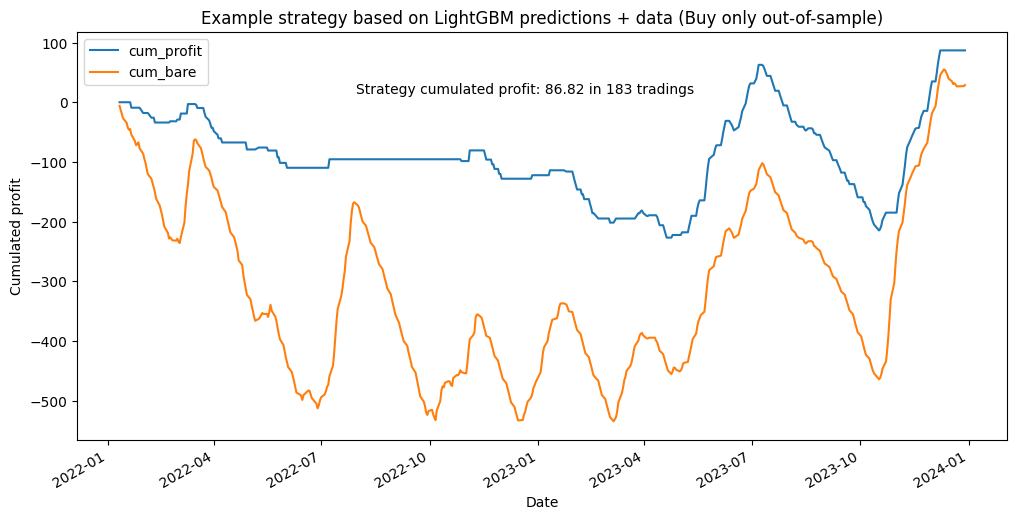

In [45]:
plot_strategy(strategy_df, "LightGBM", "+ data (Buy only out-of-sample)")

In [46]:
compare_df["mmar_cum_profit_out"] = strategy_df["cum_profit"].values
compare_df["mmar_cum_bare_out"] = strategy_df["cum_bare"].values

## Compare the two predictions

In [47]:
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [48]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_out,cum_profit_out,mmar_rf_pred_out,mmar_cum_profit_out,mmar_cum_bare_out
8,0,0.000000,1,-9.180009,-54.219991
11,1,1.610006,0,-9.180009,-70.309996
12,1,4.660012,0,-9.180009,-67.259990
14,0,4.660012,1,-18.020009,-86.099990
16,1,-1.979988,0,-18.020009,-101.259990
...,...,...,...,...,...
471,0,38.060060,1,-43.940074,-107.170052
472,0,38.060060,1,-42.670062,-105.900040
478,0,79.780013,1,12.729885,-40.720106
483,0,115.379999,1,63.809868,22.679871


In [49]:
compare_df[mask_out].shape

(303, 5)

In [50]:
compare_df.sum(axis=0)

bare_rf_pred_out          366.000000
cum_profit_out         -37113.559955
mmar_rf_pred_out          183.000000
mmar_cum_profit_out    -44553.307361
mmar_cum_bare_out     -153910.617899
dtype: float64

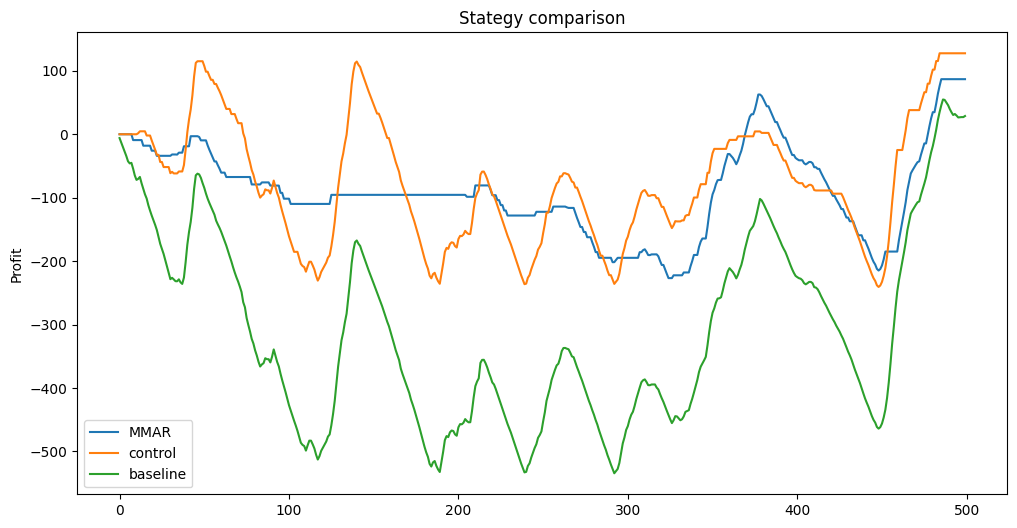

In [51]:
compare_df[["mmar_cum_profit_out", "cum_profit_out", "mmar_cum_bare_out"]].rename(
    {
        "mmar_cum_profit_out": "MMAR",
        "cum_profit_out": "control",
        "mmar_cum_bare_out": "baseline",
    },
    axis=1,
).plot(figsize=(12, 6), title="Stategy comparison", ylabel="Profit")
plt.show()